# Week 15 - 5/2/18

**OBJECTIVES**

- See if we can work out a form for $\gamma$ which minimises $\epsilon$ when scaling
- Look deeper to see whether it matters if you use the real London dataset or random/uniform etc.

In [1]:
%load_ext autoreload
%autoreload 2

## Exploring heterogeneity effects

We want to know whether the specific distribution of a city really affects the $\epsilon$ values, let's try **four different cases**: Original London Distribution (**OLD**), LD but with uniform masses (**ULD**), LD but with random locations (**RLD**), and then a random distribution with uniform masses (**RUD**).

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from hm.analysis.scaling.plots import *
from hm.analysis.scaling.pop_hierarchy import pop_hier

In [3]:
master_df = pd.read_csv("../../data/LSOA populations and areas 2011 (merged).csv")

In [ ]:
lon_df = master_df[master_df['Easting'] < 561966][master_df['Easting'] > 493024][master_df['Northing'] < 207218][master_df['Northing'] > 150912]

In [20]:
d_maxs = [1000]
df = lon_df
N = 20 # number of bins

Just get some values from the original data that will be useful.

In [6]:
df['Area'].mean()

635647.08726675005

In [9]:
df['TotPop2011'].mean()

1678.4175878567894

In [7]:
len(df)

6061

In [14]:
df['Easting'].describe()

count      6061.000000
mean     179971.964197
std       10945.227788
min      150941.000000
25%      172677.000000
50%      180420.000000
75%      187313.000000
max      207206.000000
Name: Northing, dtype: float64

In [15]:
df['Northing'].describe()

count      6061.000000
mean     179971.964197
std       10945.227788
min      150941.000000
25%      172677.000000
50%      180420.000000
75%      187313.000000
max      207206.000000
Name: Northing, dtype: float64

Now create the new dataframes.

In [18]:
# Original London
OLD_df = df.copy()

# Uniform Masses
ULD_df = df.copy()
ULD_df['TotPop2011'] = df['TotPop2011'].mean() # not an integer but I don't think this will make a difference

# Random Locations
RLD_df = df.copy()
# just scale the coordinates to be bounded by the same values as the dataset
locs = np.random.rand(len(df),2)*np.array([df['Easting'].max()-df['Easting'].min(), df['Northing'].max()-df['Northing'].min()]) + np.array([df['Easting'].min(), df['Northing'].min()])
RLD_df['Easting'] = locs[:,0]
RLD_df['Northing'] = locs[:,1]

# Random locations and uniform masses
RUD_df = df.copy()
RUD_df['Easting'] = locs[:,0]
RUD_df['Northing'] = locs[:,1]
RUD_df['TotPop2011'] = df['TotPop2011'].mean()

In [21]:
OLD_h = pop_hier(OLD_df, d_maxs)
ULD_h = pop_hier(ULD_df, d_maxs)
RLD_h = pop_hier(RLD_df, d_maxs)
RUD_h = pop_hier(RUD_df, d_maxs)

Let's use Level 3 ($d_{max} = 1000$) for all distributions.

In [ ]:
OLD_epsList, OLD_DMList = eps_hier(OLD_h, model='g')

In [ ]:
ULD_epsList, ULD_DMList = eps_hier(ULD_h, model='g')

This is three times as quick with uniform masses, interesting.

In [ ]:
RLD_epsList, RLD_DMList = eps_hier(RLD_h, model='g')

In [ ]:
RUD_epsList, RUD_DMList = eps_hier(RUD_h, model='g')

In [27]:
epsList = [OLD_epsList[0], ULD_epsList[0], RLD_epsList[0], RUD_epsList[0]]
DMList = [OLD_DMList[0], ULD_DMList[0], RLD_DMList[0], RUD_DMList[0]]

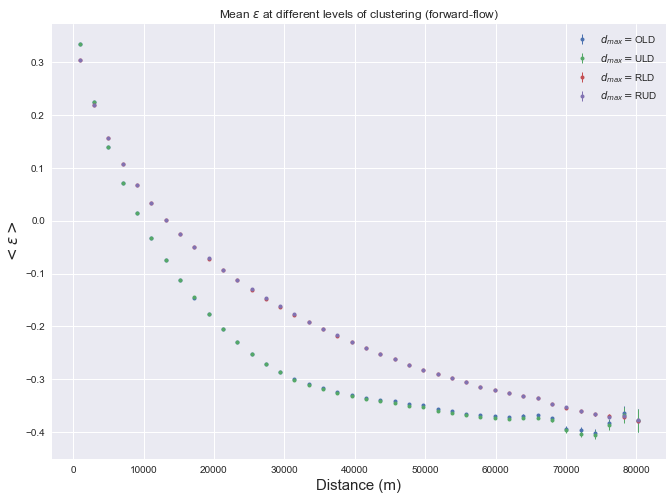

In [33]:
eps_distance_hier(epsList, DMList, ['OLD','ULD','RLD','RUD'], 40)
plt.show()

*So* this tells us that whilst uniform mass doesn't really change $\epsilon$, the location distribution *does*. This is nice because it means that we can probably use a uniform mass distribution which gives us a 3x speed up.

## Effects of number of locations 

To optimise, it'd be ideal if we could use a small number of locations for speed. Therefore I'm going to plot epsilon as above but instead making different sizes of random selection from the dataset. 

In [38]:
dEdN = np.array([df['Easting'].max()-df['Easting'].min(), df['Northing'].max()-df['Northing'].min()])

In [72]:
minEminN = np.array([df['Easting'].min(), df['Northing'].min()])
minEminN

array([493171, 150941])

In [73]:
windows = np.array([np.linspace(minEminN[0], minEminN[0]+dEdN[0], 5)[1:], np.linspace(minEminN[1], minEminN[1]+dEdN[1], 5)[1:]]).T
windows

array([[ 510350.5 ,  165007.25],
       [ 527530.  ,  179073.5 ],
       [ 544709.5 ,  193139.75],
       [ 561889.  ,  207206.  ]])

In [55]:
def slice_df(df, window, minEminN):
    ndf = df[df['Easting'] < window[0]][df['Easting'] > minEminN[0]][df['Northing'] < window[1]][df['Northing'] > minEminN[1]]
    return ndf

In [ ]:
df1 = slice_df(df, windows[0], minEminN)
df2 = slice_df(df, windows[1], minEminN)
df3 = slice_df(df, windows[2], minEminN)
df4 = slice_df(df, windows[3], minEminN)

In [62]:
h1 = pop_hier(df1, d_maxs)
h2 = pop_hier(df2, d_maxs)
h3 = pop_hier(df3, d_maxs)
h4 = pop_hier(df4, d_maxs)

In [ ]:
eps1, DM1 = eps_hier(h1, model='g') # 0s

In [ ]:
eps2, DM2 = eps_hier(h2, model='g') # 16s

In [ ]:
eps3, DM3 = eps_hier(h3, model='g') # Longer

In [ ]:
eps4, DM4 = eps_hier(h4, model='g') # 6:13

In [69]:
epsList = [eps1[0], eps2[0], eps3[0], eps4[0]]
DMList = [DM1[0], DM2[0], DM3[0], DM4[0]]

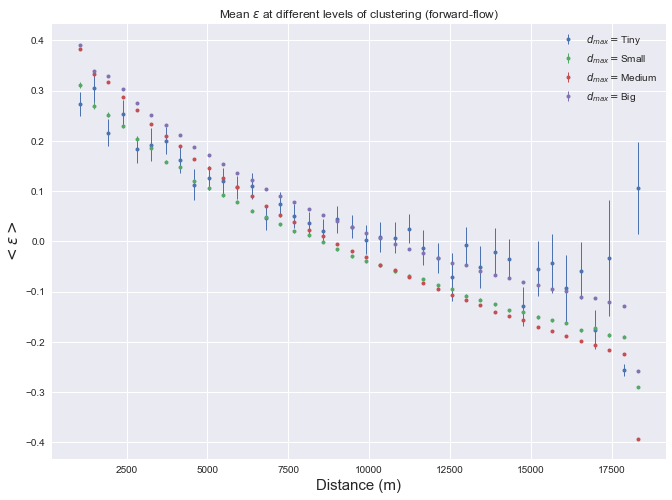

In [70]:
eps_distance_hier(epsList, DMList, ['Tiny','Small','Medium','Big'], 40)
plt.show()

The tiny window is too small. The small one isn't too bad though - we could use this for testing perhaps.

In [74]:
len(df2)

1231

In [ ]:
small_df = df[df['Easting'] < 527530][df['Easting'] > 493171][df['Northing'] < 179073.5][df['Northing'] > 150941]